# OpenClassrooms - Ingenieur IA
# Projet 6 - Avis Restau
# Améliorez le produit IA de votre start-up

## Objectif du projet : 
- **Détecter les sujets d’insatisfaction présents dans les commentaires postés sur la plateforme**
- **Labelliser automatiquement les photos postées sur la plateforme.**
- **Collecter de nouvelles données via l’API Yelp**

## Trois parties :
- **Partie A : analyser les commentaires pour détecter les différents sujets d’insatisfaction**
- **Partie B : analyser les photos pour déterminer les catégories des photos**
- **Partie C : collecter un échantillon de données via l’API Yelp**

## Plan :
- **Partie B : analyser les photos pour déterminer les catégories des photos**
    - Pré-traitement des images
        - Création des descripteurs avec l'algorithme SIFT
        - Création du dictionnaire des Visual Words
        - Création des Bags of Features (Bags of Visual Words)
     
    - Utilisation de techniques de réduction de dimension
        - Réduction de dimension PCA
        - Réduction de dimension TSNE
        
    - Visualisation des données de grandes dimensions
        - Analyse visuelle : affichage TSNE
        
    - Evaluation du modèle
        - Analyse mesure : score ARI de similarité catégories images / clusters
        
    - Deux versions étudiées
        - Version 1 : traitement des images = conversion en nuances de gris + égalisation de l'histogramme
        - Version 2 : traitement des images = conversion en nuances de gris + égalisation de l'histogramme + application d'un filtre gaussien pour filtrer le bruit
        
    - Extraction des features avec utilisation d'un modèle CNN + Transfer Learning
        - Mise en place du modèle pré-entrainé
        - Extraction des features avec le modèle pré-entrainé
        - Fonction 'pipeline' pour l'analyse
        
    - Conclusion générale
    
## Note :
 - Afin de rendre le travail effectué compréhensible et visualisable, nous avons :
     - décrit de façon simple les différentes étapes et les algorithmes utilisés
     - ajouté de nombreux graphiques et utilisé des algorithmes et bibliothèques dédiés à la visualisation

In [1]:
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from os import listdir

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import metrics

import json

import cv2

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model

In [3]:
pd.set_option('display.max_column', 100)
pd.set_option('display.max_row', 100)

## Remarque préliminaire :
- Les différentes étapes du projet sont écrites sous forme de fonction
- Ces fonctions permettent d'automatiser l'analyse
- Une fonction 'pipeline' regroupant ces fonctions est utilisée pour la version 2 de la modélisation utilisant l'algorithme SIFT (voir cellule 56 ci-dessous)

# Partie B : analyser les photos pour déterminer les catégories des photos

## Chargement des données

### Chargement de la description des photos

In [4]:
path_desc_photos = './yelp_photos/photos.json'

In [5]:
def load_desc_photos(path_desc_photos):
    df_description_photos = pd.read_json((path_desc_photos), lines=True)
    print("Chargement des descriptions des photos : OK")
    return df_description_photos

In [6]:
df_description_photos = load_desc_photos(path_desc_photos)

Chargement des descriptions des photos : OK


In [7]:
print(f"Nombre de descriptions photos : {df_description_photos.shape[0]}")

Nombre de descriptions photos : 200000


In [8]:
print("Nombre de descriptions photos par catégorie : ")
df_description_photos['label'].value_counts()

Nombre de descriptions photos par catégorie : 


menu        40000
drink       40000
interior    40000
outside     40000
food        40000
Name: label, dtype: int64

Diagramme circulaire du nombre de descriptions photos par catégorie : 


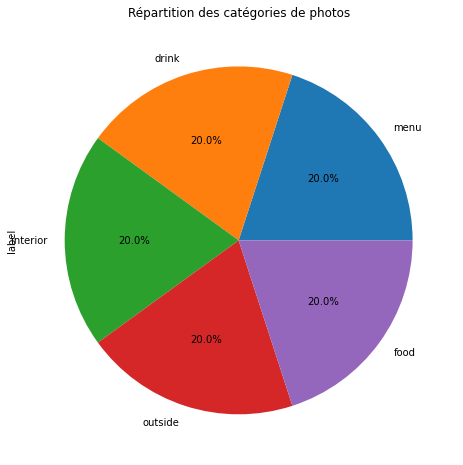

In [9]:
print("Diagramme circulaire du nombre de descriptions photos par catégorie : ")
_=df_description_photos['label'].value_counts().plot(kind='pie',figsize=(10,8),autopct='%1.1f%%',title="Répartition des catégories de photos")

#### Nous retenons un échantillon de 1 500 descriptions photos par catégorie, ce qui fait 7 500 descriptions photos au total

In [10]:
nb_photos_desc_sample = 1500

In [11]:
df_description_photos_sample = df_description_photos.groupby('label').head(nb_photos_desc_sample).reset_index(drop=True)

In [12]:
print(f"Nombre de descriptions photos de l'échantillon : {df_description_photos_sample.shape[0]}")

Nombre de descriptions photos de l'échantillon : 7500


In [13]:
print("Nombre de descriptions photos de l'échantillon par catégorie : ")
df_description_photos_sample['label'].value_counts()

Nombre de descriptions photos de l'échantillon par catégorie : 


interior    1500
menu        1500
food        1500
drink       1500
outside     1500
Name: label, dtype: int64

Diagramme circulaire du nombre de photos de l'échantillon par catégorie : 


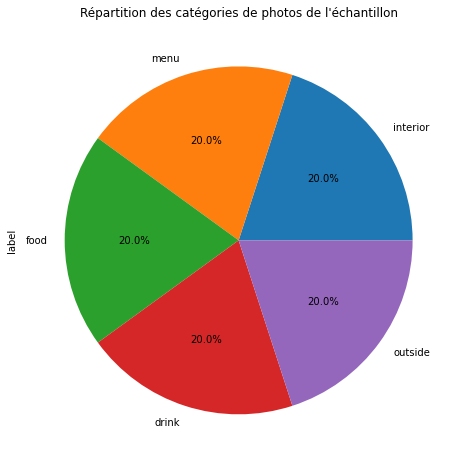

In [14]:
print("Diagramme circulaire du nombre de photos de l'échantillon par catégorie : ")
_=df_description_photos_sample['label'].value_counts().plot(kind='pie',figsize=(10,8),autopct='%1.1f%%',title="Répartition des catégories de photos de l'échantillon")

### Chargement des photos

In [15]:
path_photos = './yelp_photos/photos/'

In [16]:
def load_photos(path_photos):
    list_photos = [file for file in listdir(path_photos)]
    print("Chargement des photos : OK")
    return list_photos

In [17]:
list_photos = load_photos(path_photos)

Chargement des photos : OK


#### Nous récupèrons les photos correspondantes aux descriptions photos de l'échantillon

In [18]:
list_photos_sample = [photo for photo in listdir(path_photos) and df_description_photos_sample['photo_id']]

#### Création de listes de photos par catégorie

In [19]:
list_photos_outside=[list_photos_sample[i] for i in range(len(list_photos_sample)) if df_description_photos_sample["label"][i]=="outside"]
list_photos_drink=[list_photos_sample[i] for i in range(len(list_photos_sample)) if df_description_photos_sample["label"][i]=="drink"]
list_photos_interior=[list_photos_sample[i] for i in range(len(list_photos_sample)) if df_description_photos_sample["label"][i]=="interior"]
list_photos_food=[list_photos_sample[i] for i in range(len(list_photos_sample)) if df_description_photos_sample["label"][i]=="food"]
list_photos_menu=[list_photos_sample[i] for i in range(len(list_photos_sample)) if df_description_photos_sample["label"][i]=="menu"]

In [20]:
print(f"Nombre de photos de l'échantillon : {len(list_photos_sample)}")
print(f"Nombre de photos de l'échantillon par catégorie : {len(list_photos_drink)}")

Nombre de photos de l'échantillon : 7500
Nombre de photos de l'échantillon par catégorie : 1500


### Affichage d'exemples de photos par catégorie

In [21]:
list_labels = ["outside", "drink", "interior", "food", "menu"]

In [22]:
def list_fct(name) :
    list_photos_name = [list_photos_sample[i] for i in range(len(list_photos_sample)) if df_description_photos_sample["label"][i]==name]
    return list_photos_name

In [23]:
def print_photos_sample(path_photos):
    for label in list_labels :
        print("Photos de la catégorie : ", label)
        for i in range(3):
            plt.subplot(130 + 1 + i)
            filename = path_photos + list_fct(label)[i] +'.jpg'
            photo = cv2.imread(filename)
            plt.imshow(photo)
        plt.show()

Photos de la catégorie :  outside


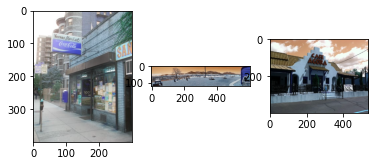

Photos de la catégorie :  drink


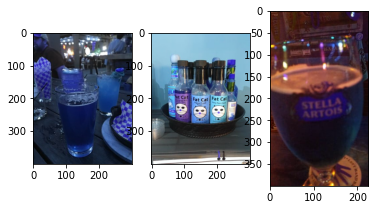

Photos de la catégorie :  interior


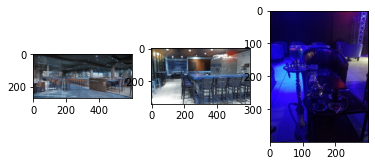

Photos de la catégorie :  food


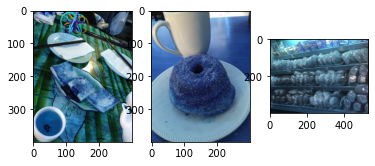

Photos de la catégorie :  menu


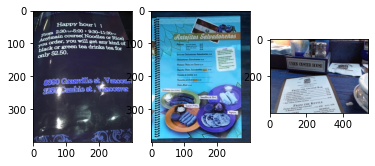

In [24]:
print_photos_sample(path_photos)

## Pré-traitement des images

### Pré-traitement des images en utilisant l'algorithme SIFT
- L'algorithme SIFT permet grâce à des traitements mathématiques complexes de :
    - Trouver les points d'intérêt dans une image (les keypoints)
    - Décrire ces points d'intérêt (les descripteurs)
- C'est un algorithme de référence dans ce domaine

### Exemple de détermination et affichage des descripteurs SIFT pour une photo

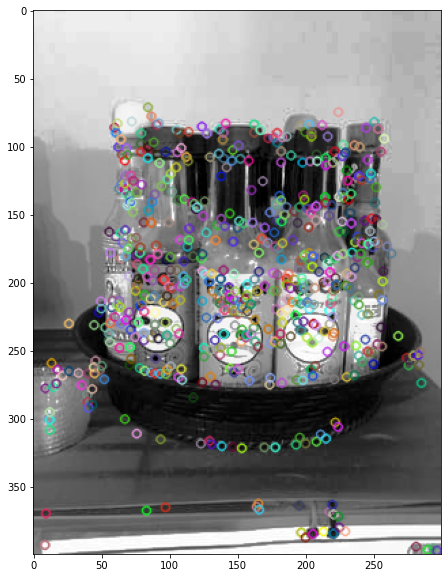

Descripteurs :  (687, 128)

[[  0.   0.   0. ...   0.   0.   0.]
 [ 61.   1.   0. ...   0.   0.   0.]
 [  6.   1.   0. ...  58.   5.   5.]
 ...
 [  3.   0.   0. ...   0. 138.  44.]
 [  0.   1.   0. ...   0.   0.   2.]
 [  0.  12. 173. ...   0.   0.   0.]]


In [25]:
sift = cv2.SIFT_create()

photo = cv2.imread(path_photos+df_description_photos_sample['photo_id'][1]+'.jpg',0) # convert in gray
photo = cv2.equalizeHist(photo)   # equalize image histogram

keypoints, descriptors = sift.detectAndCompute(photo, None)
photo = cv2.drawKeypoints(photo, keypoints, photo)

plt.figure(figsize=(20,10))
plt.imshow(photo)
plt.show()
print("Descripteurs : ", descriptors.shape)
print()
print(descriptors)

## Version 1 : 
- Le traitement effectué sur les images est le suivant :
    - Conversion en nuances de gris
    - Egalisation de l'histogramme

### Créations des descripteurs de chaque photo (Extraction des features)
- Création d'une liste de descripteurs par image qui sera utilisée pour réaliser les histogrammes par image
- Un descripteur est un vecteur qui décrit la zone d'intérêt
- Création d'une liste de descripteurs pour l'ensemble des images qui sera utilisée pour créer les clusters de descripteurs

In [26]:
def build_descriptors(list_photos_sample, path_photos):
    sift_descriptors = []
    sift = cv2.SIFT_create(500)

    for photo_num in range(len(list_photos_sample)) :
        photo_path = path_photos+list_photos_sample[photo_num]+'.jpg'

        photo = cv2.imread(photo_path, 0) # convert in gray
        photo = cv2.equalizeHist(photo)   # equalize image histogram  
     
        keypoints, descriptors = sift.detectAndCompute(photo, None)
        sift_descriptors.append(descriptors)

    sift_descriptors_by_photo = np.asarray(sift_descriptors)
    sift_descriptors_all = np.concatenate(sift_descriptors_by_photo, axis=0)
    length_descriptors = len(descriptors)
    
    print("Création des descripteurs : OK")
    
    return sift_descriptors_by_photo, sift_descriptors_all, length_descriptors

In [27]:
sift_descriptors_by_photo, sift_descriptors_all, length_descriptors = build_descriptors(list_photos_sample, path_photos)

Création des descripteurs : OK


In [28]:
print("Nombre de descripteurs : ", sift_descriptors_all.shape[0])
print("Taille des descripteurs : ", sift_descriptors_all.shape[1])
print("Longueur des descripteurs : ", length_descriptors)

Nombre de descripteurs :  3679794
Taille des descripteurs :  128
Longueur des descripteurs :  500


### Création des clusters de descripteurs (Dictionnaire des Visual Words)
- Création des Visual Words : les features qui se déclinent en plusieurs versions sont appelées des Visual Words (par analogie au traitement du texte)
    - On regroupe les features similaires dans des Visual Words
    - Pour créer le dictionnaire des Visual Words, on utilise un algorithme de clustering
    - En sortie du clustering, les centroides (centre des clusters) correspondent au regroupement des features similaire en visual words -> Centroides = Visual Words
    - On obtient un disctionnaire de Visual Words
- Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [29]:
def clustering_descriptors(sift_descriptors_all):
    # Determination number of clusters
    k = int(round(np.sqrt(len(sift_descriptors_all)),0))
    print("Nombre de clusters de descripteurs estimés : ", k)
    print("Création de", k, "Visual Words")

    # Clustering
    kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=1)
    kmeans.fit(sift_descriptors_all)
    
    print("Clustering : OK")
    
    return kmeans

In [30]:
kmeans = clustering_descriptors(sift_descriptors_all)

Nombre de clusters de descripteurs estimés :  1918
Création de 1918 Visual Words
Clustering : OK


In [31]:
print("Dictionnaire des Visual Words :")
dico_visual_words = kmeans.cluster_centers_ # ce sont les visuals words
dico_visual_words

Dictionnaire des Visual Words :


array([[  0.  ,   0.  ,  10.  , ...,  37.  ,  75.  ,   3.  ],
       [  0.8 ,   7.2 ,   8.6 , ...,   0.2 ,   2.4 ,  17.6 ],
       [ 33.  ,  25.25,  31.5 , ...,   3.25,   6.  ,  17.25],
       ...,
       [  0.5 ,  17.  ,  98.5 , ...,   0.  ,   0.  ,   1.  ],
       [  0.  ,   0.  ,   0.  , ...,  18.  ,   9.  ,  10.  ],
       [164.  ,  53.  ,   0.  , ...,   0.  ,   0.  ,  14.  ]],
      dtype=float32)

In [32]:
print("Nombre de Visual Words : ", dico_visual_words.shape[0])
print("Taille des Visual Words : ", dico_visual_words.shape[1])

Nombre de Visual Words :  1918
Taille des Visual Words :  128


### Création des Bags Of Visual features des images
- Construction des histogrammes 
    - Il reste à décrire les images en fonction de ces Visual Words
    - Pour chaque image :
       - prédiction des numéros de cluster de chaque descripteur
       - création d'un histogramme qui indique la fréquence d'apparition de chaque Visual Word dans l'image = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

> On obtient le Bag Of Visual Features d'une image qui est le vecteur dans lequel on a stocké les valeurs de l'histogramme et que l'on a normalisé

In [33]:
def build_photo_histogram(kmeans, photo_descriptors, photo_num, length_descriptors):
    # We get the visual words corresponding to each descriptor of the photo
    photo_descriptors_predict = kmeans.predict(photo_descriptors)
    
    # Length of histogram = size of the cluster centers
    photo_histogram = np.zeros(len(kmeans.cluster_centers_))
    
    if length_descriptors==0 : print("problème histogramme image  : ", photo_num)
    for i in photo_descriptors_predict:
        photo_histogram[i] += 1.0/length_descriptors
    
    return photo_histogram

In [34]:
def build_bag_features(kmeans, sift_descriptors_by_photo, length_descriptors):
    # Creation of a matrix of histograms
    histogram_vectors=[]

    for i, photo_descriptors in enumerate(sift_descriptors_by_photo) :
        photo_histogram = build_photo_histogram(kmeans, photo_descriptors, i, length_descriptors) #calculates the histogram
        histogram_vectors.append(photo_histogram) #histogram is the feature vector

    # Bag of visual features
    photo_features = np.asarray(histogram_vectors)
    
    print("Création des bags of features : OK")
    
    return photo_features

In [35]:
photo_features = build_bag_features(kmeans, sift_descriptors_by_photo, length_descriptors)

Création des bags of features : OK


In [36]:
print("Taille de la matrice des Bags of Visual Features :")
photo_features.shape

Taille de la matrice des Bags of Visual Features :


(7500, 1918)

## Utilisation de techniques de réduction de dimension

### Réduction de dimension PCA : Principal Components Analysis
- La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
- Cela permettra une meilleure séparation des données lors de l'utilisation de l'algorithme T-SNE ainsi qu'une réduction du temps de traitement
> Cet algorithme nous permet de réduire la dimension tout en gardant la quasi totalité de l'information 

In [37]:
print("Dimensions dataset avant réduction PCA : ", photo_features.shape)

Dimensions dataset avant réduction PCA :  (7500, 1918)


In [38]:
def pca_reduction(photo_features):
    # We keep 99% of the variance
    pca = PCA(n_components=0.99)
    photo_features_pca = pca.fit_transform(photo_features)
   
    print("Réduction de dimension PCA : OK")
    
    return photo_features_pca

In [39]:
pca_photo_features = pca_reduction(photo_features)

Réduction de dimension PCA : OK


In [40]:
print("Dimensions dataset après réduction PCA : ", pca_photo_features.shape)

Dimensions dataset après réduction PCA :  (7500, 1091)


## Visualisation des données de grandes dimensions

### Réduction de dimension et visualisation T-SNE : T-distributed Stochastic Neighbor Embedding
- Cet algorithme permet la réduction de dimension en 2 composantes T-SNE pour l'affichage en 2D des images
- Chaque image est résumée par les 2 coordonnées T-SNE qui ont été produites par réduction de dimension des Bags Of Visual Features
> Cet algorithme est particulièrement adapté pour la réduction et visualisation de données de grandes dimensions

- Le principe de cet algorithme est le suivant :
    - Il effectue une réduction de dimension tout en essayant de conserver les observations semblables proches et les observations dissemblables éloignées
    - On calcule pour chaque observation une probabilité conditionnelle en fonction de la distance aux autres observations. Ces probabilités représentent les similarités entre points de données dans l'espace initial
    - A partir de ces probabilités Pi dans l'espace de grande dimension, l'algorithme va produire une nouvelle distribution Qi (qui est une t-distribution de Student) dans l'espace de plus petite dimension en minimisant une fonction de coût
    - La nouvelle distribution Qi est une T-distribution de Student et la fonction de coût la divergence de Kullback-Leibler entre la probabilité d'origine et la probabilité d'arrivée
    - Avec la nouvelle distribution on peut reconstruire l'ensemble de points dans l'epace de redéfinition de plus petite dimension
    - L'optimisation de la fonction de coût se fait grâce à une descente de gradient

In [41]:
def tsne_reduction(pca_photo_features, df_description_photos_sample):
    tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=1)
    photo_features_tsne = tsne.fit_transform(pca_photo_features)

    df_photo_features_tsne = pd.DataFrame(photo_features_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_photo_features_tsne["label"] = df_description_photos_sample["label"]

    print("Réduction de dimension TSNE : OK")
    
    return df_photo_features_tsne

In [42]:
df_photo_features_tsne = tsne_reduction(pca_photo_features, df_description_photos_sample)

Réduction de dimension TSNE : OK


In [43]:
print("Dimension du dataframe tsne :")
print(df_photo_features_tsne.shape)

Dimension du dataframe tsne :
(7500, 3)


In [44]:
print("Dataframe tsne :")
df_photo_features_tsne

Dataframe tsne :


,tsne1,tsne2,label
0,20.267456,-13.357003,drink
1,6.767444,-0.776020,drink
2,-5.100426,-2.601486,drink
3,-0.597271,3.243889,drink
4,-5.626867,0.528084,drink
...,...,...,...
7495,-21.259157,-8.818829,menu
7496,-20.053650,12.102979,menu
7497,-15.780569,23.374323,menu
7498,-38.735561,13.306304,menu


### Analyse visuelle : affichage T-SNE selon la catégorie des images
- On va regarder si ces images dans l'espace TSNE sont groupées selon la même catégorie et séparées selon les différentes catégories
> Si c'est le cas, cela signifie que l'on a réussi à séparer les images selon leur catégorie (de façon non supervisée)

In [45]:
def tsne_visualization(df_photo_features_tsne):
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="tsne1", y="tsne2", hue="label", data=df_photo_features_tsne, legend="brief",
        palette=sns.color_palette('tab10', n_colors=5), s=20, alpha=0.5)

    plt.title('Visualisation en dimension réduite (TSNE) selon les vraies catégories', fontsize = 26, pad = 35)
    plt.xlabel('Dimension réduite 1 (tsne1)', fontsize = 26)
    plt.ylabel('Dimension réduite 2 (tsne2)', fontsize = 26)
    plt.legend(prop={'size': 14}) 

    plt.show()

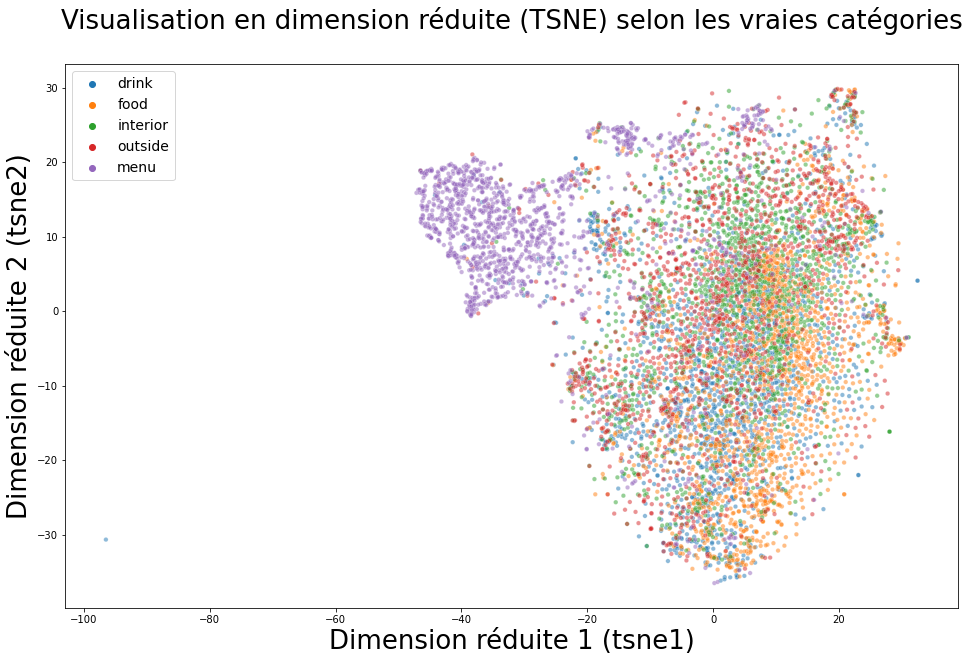

In [46]:
tsne_visualization(df_photo_features_tsne)

#### Conclusion :
- Les résultats ne sont pas très satisfaisants
- Seule la catégorie 'menu' est bien séparée

## Evaluation du modèle

### Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir de la modélisation T-SNE

In [47]:
def tsne_clustering(df_photo_features_tsne):
    clusters = KMeans(n_clusters=5, random_state=1)
    clusters.fit(df_photo_features_tsne[['tsne1', 'tsne2']].to_numpy())

    df_photo_features_tsne["cluster"] = clusters.labels_
    
    print("Clustering TSNE : OK")
    
    return df_photo_features_tsne

In [48]:
df_photo_features_tsne_clusters = tsne_clustering(df_photo_features_tsne)

Clustering TSNE : OK


In [49]:
print("Dimension du dataframe tsne :")
print(df_photo_features_tsne_clusters.shape)

Dimension du dataframe tsne :
(7500, 4)


In [50]:
print("Dataframe tsne :")
df_photo_features_tsne_clusters

Dataframe tsne :


,tsne1,tsne2,label,cluster
0,20.267456,-13.357003,drink,0
1,6.767444,-0.776020,drink,0
2,-5.100426,-2.601486,drink,4
3,-0.597271,3.243889,drink,4
4,-5.626867,0.528084,drink,4
...,...,...,...,...
7495,-21.259157,-8.818829,menu,4
7496,-20.053650,12.102979,menu,1
7497,-15.780569,23.374323,menu,1
7498,-38.735561,13.306304,menu,1


###  Affichage des images selon les clusters

In [51]:
def tsne_clusters_vizualization(df_photo_features_tsne_clusters):
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="cluster",
        palette=sns.color_palette('tab10', n_colors=5), s=20, alpha=0.5,
        data=df_photo_features_tsne_clusters,
        legend="brief")

    plt.title('Visualisation en dimension réduite (TSNE) selon les clusters', fontsize = 26, pad = 35)
    plt.xlabel('Dimension réduite 1 (tsne1)', fontsize = 26)
    plt.ylabel('Dimension réduite 2 (tsne2)', fontsize = 26)
    plt.legend(prop={'size': 14}) 

    plt.show()

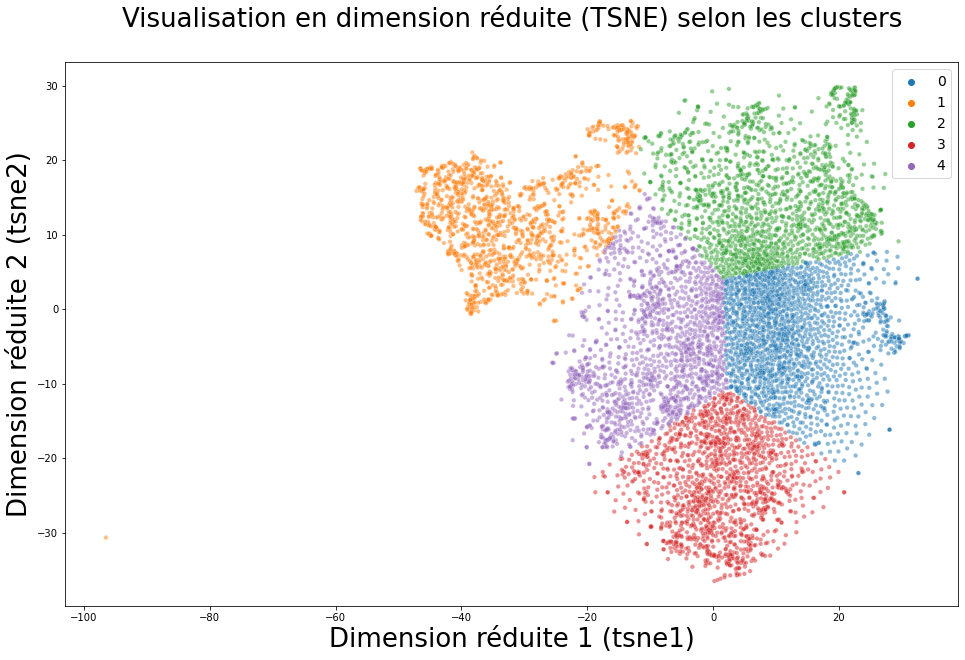

In [52]:
tsne_clusters_vizualization(df_photo_features_tsne_clusters)

###  Calcul du score ARI : score de similarité catégories images / clusters

In [53]:
def compute_ari_score(labels, clusters):
    ari_score = metrics.adjusted_rand_score(labels, clusters)
    return ari_score

In [54]:
labels = df_photo_features_tsne_clusters['label']
clusters = df_photo_features_tsne_clusters['cluster']
score_ari = compute_ari_score(labels, clusters)
print('Score ARI = %.3f' % (score_ari))

Score ARI = 0.179


### Conclusion : 
- Le score ARI de 0.18 est faible
- Seul le cluster 1 est identifiable, il correspond à la catégorie 'menu'

## Version 2 :
- Le traitement effectué sur les images est le suivant :
    - Conversion en nuances de gris
    - Egalisation de l'histogramme
    - Application d'un filtre gaussien pour filtrer le bruit

In [55]:
def build_descriptors_v2(list_photos_sample, path_photos):
    sift_descriptors = []
    sift = cv2.SIFT_create(500)

    for photo_num in range(len(list_photos_sample)) :
        photo_path = path_photos+list_photos_sample[photo_num]+'.jpg'

        photo = cv2.imread(photo_path, 1)
        #photo = cv2.resize(photo, (224, 224))
        photo = cv2.cvtColor(photo, cv2.COLOR_RGB2GRAY)
        photo = cv2.equalizeHist(photo)
        #photo = cv2.medianBlur(photo,5)
        photo = cv2.GaussianBlur(photo, (5, 5), 0)
     
        keypoints, descriptors = sift.detectAndCompute(photo, None)
        sift_descriptors.append(descriptors)

    sift_descriptors_by_photo = np.asarray(sift_descriptors)
    sift_descriptors_all = np.concatenate(sift_descriptors_by_photo, axis=0)
    length_descriptors = len(descriptors)
    
    print("Création des descripteurs : OK")
    
    return sift_descriptors_by_photo, sift_descriptors_all, length_descriptors

#### Remarque :
- Nous créons une fonction 'pipeline' regroupant les fonctions de  preprocessing, modélisation et visualisation
- Cela permet d'automatiser le processus

In [56]:
def pipeline_photos_analysis(list_photos_sample, path_photos, df_description_photos_sample):
    # Création des descripteurs
    sift_descriptors_by_photo, sift_descriptors_all, length_descriptors = build_descriptors_v2(list_photos_sample, path_photos)
    
    # Clustering : création des Visual Words
    kmeans = clustering_descriptors(sift_descriptors_all)
    
    # Création des Bags Of Visual Words
    photo_features = build_bag_features(kmeans, sift_descriptors_by_photo, length_descriptors)
    
    # Réduction de dimension PCA
    print("Dimensions dataset avant réduction PCA : ", photo_features.shape)
    photo_features_pca = pca_reduction(photo_features)
    print("Dimensions dataset après réduction PCA : ", photo_features_pca.shape)
    
    # Réduction de dimension TSNE
    df_photo_features_tsne = tsne_reduction(photo_features_pca, df_description_photos_sample)
    
    # Visualisation TSNE
    tsne_visualization(df_photo_features_tsne)
    
    # Clustering TSNE
    df_photo_features_tsne_clusters = tsne_clustering(df_photo_features_tsne)

    # Visualisation Clusters TSNE
    tsne_clusters_vizualization(df_photo_features_tsne_clusters)
    
    # Compute ARI Score
    labels = df_photo_features_tsne_clusters['label']
    clusters = df_photo_features_tsne_clusters['cluster']
    score_ari = compute_ari_score(labels, clusters)
    print('Score ARI = %.3f' % (score_ari))

Création des descripteurs : OK
Nombre de clusters de descripteurs estimés :  1882
Création de 1882 Visual Words
Clustering : OK
Création des bags of features : OK
Dimensions dataset avant réduction PCA :  (7500, 1882)
Réduction de dimension PCA : OK
Dimensions dataset après réduction PCA :  (7500, 1759)
Réduction de dimension TSNE : OK


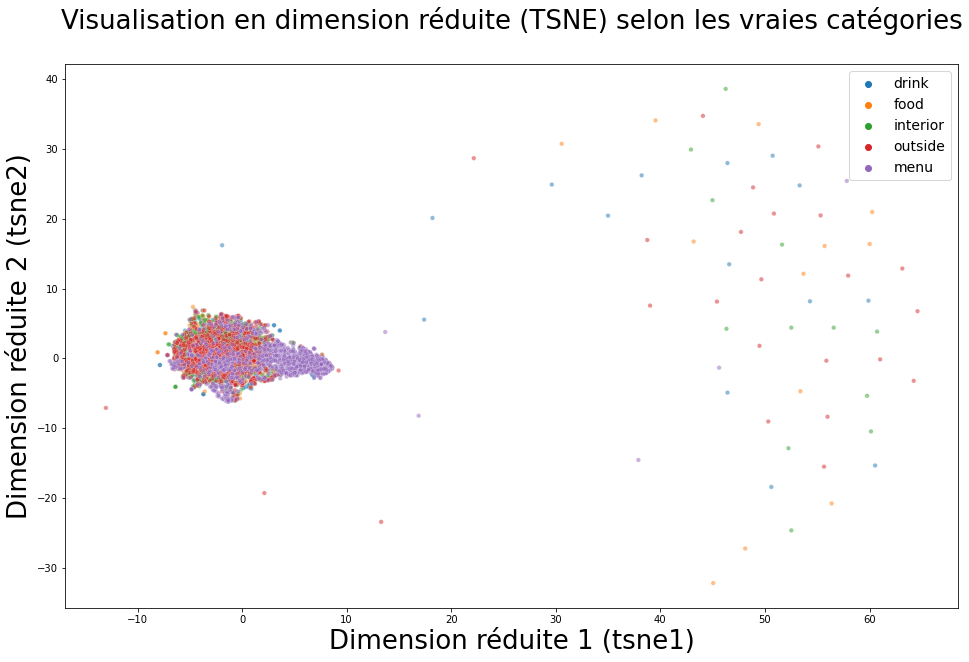

Clustering TSNE : OK


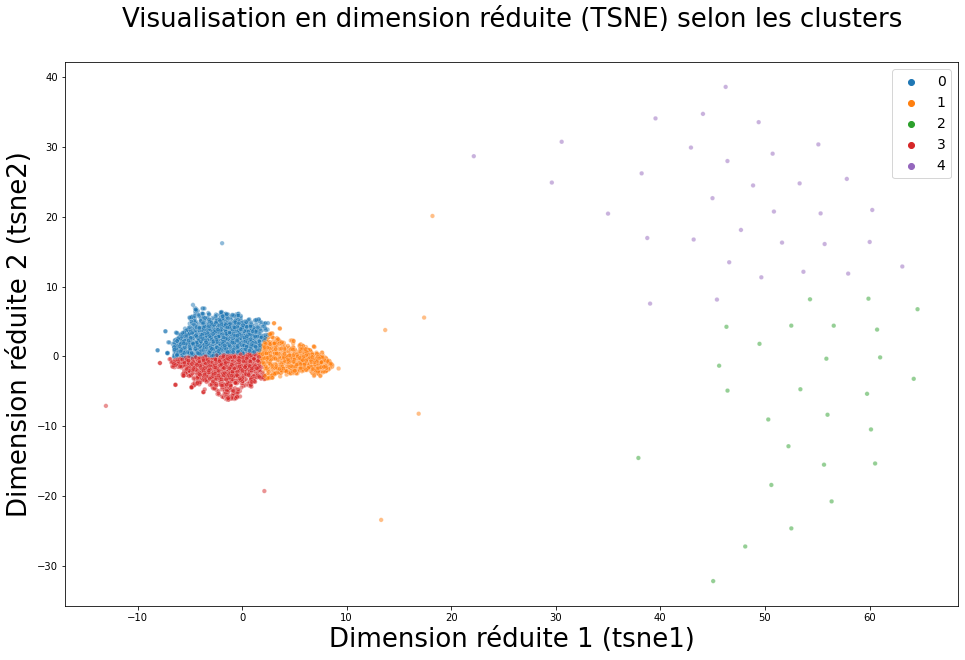

Score ARI = 0.103


In [57]:
pipeline_photos_analysis(list_photos_sample, path_photos, df_description_photos_sample)

### Conclusion : 
- Le score ARI de 0.10 est faible et inférieur à la version précédente
- Seul le cluster 1 est identifiable, il correspond à la catégorie 'menu'

## Extraction des features avec utilisation d'un modèle CNN (Convolutional Neural Network) + Transfer Learning

- On utilise un modèle pré-entrainé sur un grand nombre d'autres images
- On va utiliser les features qui sont extraites par ce modèle  pour notre probléme
- Nous allons utiliser pour cela le modèle VGG16

### Mise en place du modèle pré-entrainé

In [58]:
def get_vgg16_model(layer='fc2'):
    """Keras Model of the VGG16 network, with the output layer set to `layer`.
    The default layer is the second-to-last fully connected layer 'fc2' of
    shape (4096,).
    Parameters
    ----------
    layer : str
        which layer to extract (must be of shape (None, X)), e.g. 'fc2', 'fc1'
        or 'flatten'
    """

    base_model = VGG16(weights='imagenet', include_top=True)
    model = Model(inputs=base_model.input,
                outputs=base_model.get_layer(layer).output)
    return model

In [59]:
vgg16_model = get_vgg16_model()

In [60]:
print("Architecture du réseau VGG16 : \n")
vgg16_model.summary()

Architecture du réseau VGG16 : 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooli

### Extraction des features avec le modèle pré-entrainé

In [61]:
def build_features_transfer_learning(list_photos_sample, path_photos, model):
    features_transfer_learning = []
    
    for photo_num in range(len(list_photos_sample)) :
        photo_path = path_photos+list_photos_sample[photo_num]+'.jpg'

        photo = cv2.imread(photo_path)
        photo = cv2.resize(photo, (224, 224)) 
    
        photo = np.expand_dims(photo, axis=0)  
        photo = preprocess_input(photo)
    
        features_predict = model.predict(photo)
        features_predict_flatten = features_predict.flatten()
    
        features_transfer_learning.append(features_predict_flatten)
    
    photos_features_transfer_learning = np.asarray(features_transfer_learning)
    
    print("Création des features de photos par transfer learning : OK")
    
    return photos_features_transfer_learning

### Fonction 'pipeline' pour :
- Extraction des features
- Réduction de dimension
- Visualisation
- Evaluation

In [62]:
def pipeline_photos_analysis_transfer_learning(list_photos_sample, path_photos, df_description_photos_sample, model):
    # Création des features par transfer learning
    photos_features_transfer_learning = build_features_transfer_learning(list_photos_sample, path_photos, model)
    
    # Réduction de dimension PCA
    print("Dimensions dataset avant réduction PCA : ", photos_features_transfer_learning.shape)
    photo_features_pca = pca_reduction(photos_features_transfer_learning)
    print("Dimensions dataset après réduction PCA : ", photo_features_pca.shape)
    
    # Réduction de dimension TSNE
    df_photo_features_tsne = tsne_reduction(photo_features_pca, df_description_photos_sample)
    
    # Visualisation TSNE
    tsne_visualization(df_photo_features_tsne)
    
    # Clustering TSNE
    df_photo_features_tsne_clusters = tsne_clustering(df_photo_features_tsne)

    # Visualisation Clusters TSNA
    tsne_clusters_vizualization(df_photo_features_tsne_clusters)
    
    # Compute ARI Score
    labels = df_photo_features_tsne_clusters['label']
    clusters = df_photo_features_tsne_clusters['cluster']
    score_ari = compute_ari_score(labels, clusters)
    print('Score ARI - Transfer Learning = %.3f' % (score_ari))
    
    return photos_features_transfer_learning, df_photo_features_tsne_clusters

Création des features de photos par transfer learning : OK
Dimensions dataset avant réduction PCA :  (7500, 4096)
Réduction de dimension PCA : OK
Dimensions dataset après réduction PCA :  (7500, 2803)
Réduction de dimension TSNE : OK


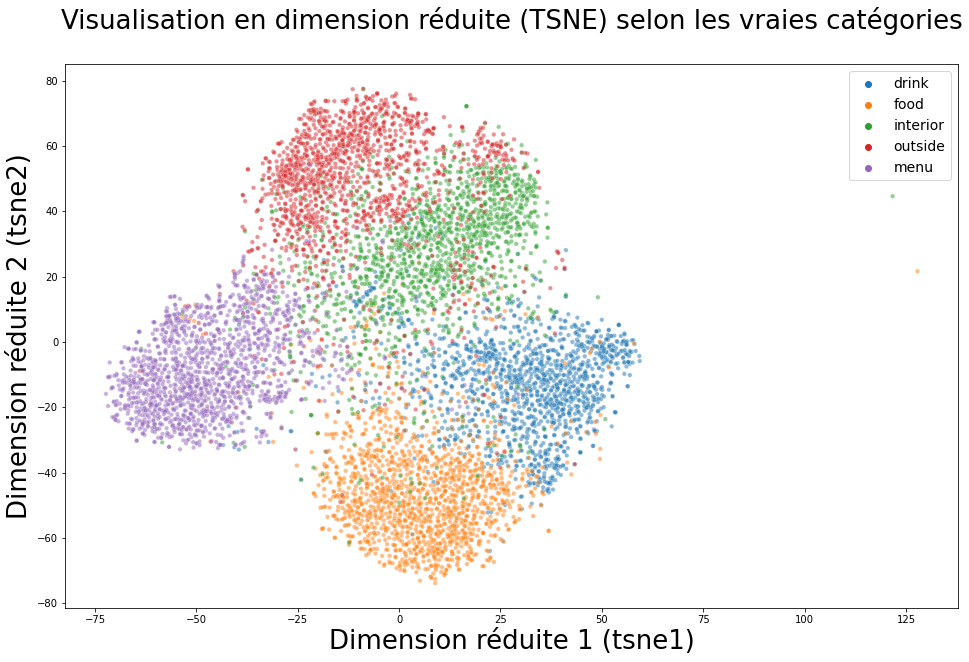

Clustering TSNE : OK


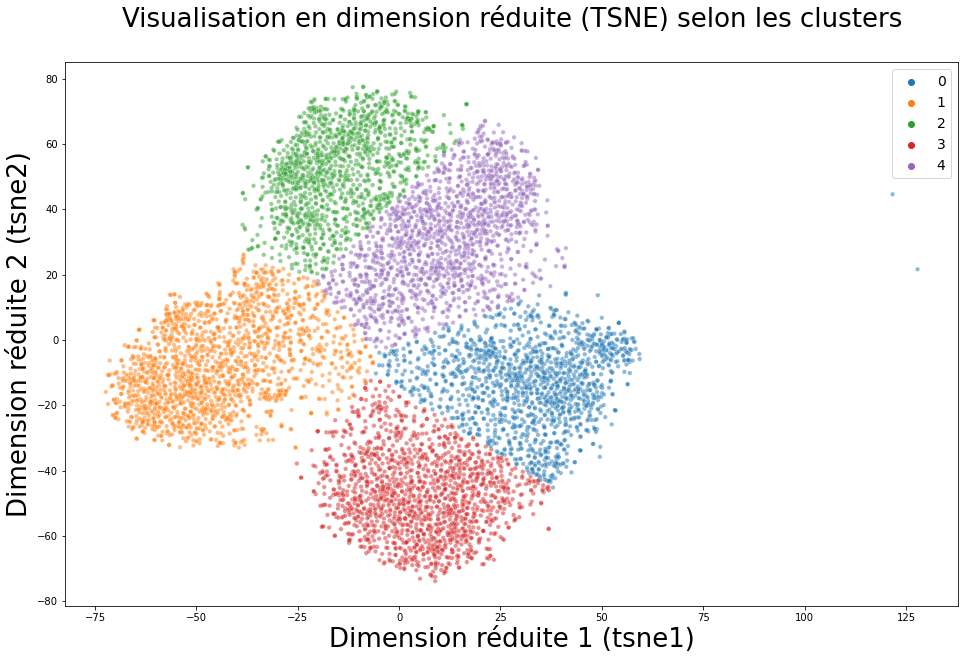

Score ARI - Transfer Learning = 0.675


In [63]:
photos_features_transfer_learning, df_photo_features_tsne_clusters = pipeline_photos_analysis_transfer_learning(list_photos_sample, path_photos, df_description_photos_sample, vgg16_model)

### Conclusion :
- Les résultats sont très bons et bien meilleurs qu'avec la modélisation précédente
- Le score ARI est proche de 0.7
- Les catégories des photos sont clairement séparables et identifiables :
    - Le cluster 0 correspond à la catégorie : **drink**
    - Le cluster 1 correspond à la catégorie : **menu**
    - Le cluster 2 correspond à la catégorie : **outside**
    - Le cluster 3 correspond à la catégorie : **food**
    - Le cluster 4 correspond à la catégorie : **interior**

### Essai clustering sur les features des photos directement (et pas sur les composantes TSNE qui représentent les features réduites)

In [64]:
photos_features_transfer_learning.shape

(7500, 4096)

In [65]:
#clusters_photos_transfer_learning = MiniBatchKMeans(5, random_state=1)
clusters_photos_transfer_learning = KMeans(5, random_state=1)

In [66]:
clusters_photos_transfer_learning.fit(photos_features_transfer_learning)

KMeans(n_clusters=5, random_state=1)

In [67]:
df_description_photos_sample['clusters_features_photo_transfer_learning'] = clusters_photos_transfer_learning.labels_

In [68]:
labels = df_description_photos_sample['label']
clusters_features = df_description_photos_sample['clusters_features_photo_transfer_learning']
score_ari = compute_ari_score(labels, clusters_features)
print('Score ARI - Transfer Learning - clusters sur les features des photos = %.3f' % (score_ari))

Score ARI - Transfer Learning - clusters sur les features des photos = 0.613


#### Le score ARI est bon mais légèrement inférieur à celui du clustering sur les composantes du modèle T-SNE (features en dimensions réduites)

## Conclusion générale :
- Les résultats avec l'algorithme SIFT ne sont pas très satisfaisants
    - Une seule catégorie de photos est clairement identifiable et séparée
    - Le score ARI est assez faible
- Les résultats sont bien meilleurs avec la modélisation CNN + Transfer Learning
    - Toutes les catégories de photos sont clairement séparables et identifiables
    - Le score ARI est élevé
> **Cette étude montre que l'objectif fixé : déterminer les catégories des photos à partir de l'analyse des photos, est atteignable en utilisant un réseau de neurones de type CNN et en faisant du Transfer Learning**